# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

**Заказчику важны:**

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных**
- **Признаки:**
    - DateCrawled — дата скачивания анкеты из базы; -
    - VehicleType — тип автомобильного кузова; +
    - RegistrationYear — год регистрации автомобиля; - после вычисления лет авто
    - Gearbox — тип коробки передач; +
    - Power — мощность (л. с.); +
    - Model — модель автомобиля; +
    - Kilometer — пробег (км); +
    - RegistrationMonth — месяц регистрации автомобиля; - после вычисления лет авто
    - FuelType — тип топлива; +
    - Brand — марка автомобиля; +
    - Repaired — была машина в ремонте или нет; +
    - DateCreated — дата создания анкеты; - после вычисления лет авто на момент публикации анкеты
    - NumberOfPictures — количество фотографий автомобиля; -
    - PostalCode — почтовый индекс владельца анкеты (пользователя); +
    - LastSeen — дата последней активности пользователя; -
- **Целевой признак:**
    - Price — цена (евро).

Для решения поставленной задачи, будем придерживаться следующих шагов:

- Загрузим данные, путь к файлу: /datasets/autos.csv.
- Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах, если они есть. Если среди признаков имеются неинформативные, удалим их.
- Подготовим выборки для обучения моделей.
- Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
- Проанализируем время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выберем лучшую модель и проверим её качество на тестовой выборке.

In [1]:
# для решения задачи подключим необходимые библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import time
RANDOM_STATE = 12345

pd.options.display.max_colwidth = 100

## Загрузка данных

In [2]:
# прочтем данные и выведем на экран
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


## Ознакомление с данными

In [3]:
#выведем общую информацию по датасету, а также отдельно количество строк и столбцов
data.info()
print(f'Количество строк {data.shape[0]} и столбцов {data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
# приведем название столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)
data.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [5]:
data = data.rename(columns={'datecrawled' : 'date_crawled', 'vehicletype' : 'vehicle_type'
                     , 'registrationyear' : 'registration_year', 'registrationmonth' : 'registration_month'
                     , 'fueltype' : 'fuel_type', 'datecreated' : 'date_created'
                     , 'numberofpictures' : 'number_of_pictures', 'postalcode' : 'postal_code'
                     , 'lastseen' : 'last_seen'})

In [6]:
# посмотрим есть ли пропуски в данных и их количесвто
print(data.isna().sum())

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


In [7]:
# выведем количество пропусков в процентном соотношении от общего количества данных
for col in range(len(data.columns)):
    print(f'Процент пропущенных данных в столбце {list(data.columns)[col]} равен \
    {(data.iloc[:, col].isna().sum() / data.shape[0] * 100).round(2)}%')

Процент пропущенных данных в столбце date_crawled равен     0.0%
Процент пропущенных данных в столбце price равен     0.0%
Процент пропущенных данных в столбце vehicle_type равен     10.58%
Процент пропущенных данных в столбце registration_year равен     0.0%
Процент пропущенных данных в столбце gearbox равен     5.6%
Процент пропущенных данных в столбце power равен     0.0%
Процент пропущенных данных в столбце model равен     5.56%
Процент пропущенных данных в столбце kilometer равен     0.0%
Процент пропущенных данных в столбце registration_month равен     0.0%
Процент пропущенных данных в столбце fuel_type равен     9.28%
Процент пропущенных данных в столбце brand равен     0.0%
Процент пропущенных данных в столбце repaired равен     20.08%
Процент пропущенных данных в столбце date_created равен     0.0%
Процент пропущенных данных в столбце number_of_pictures равен     0.0%
Процент пропущенных данных в столбце postal_code равен     0.0%
Процент пропущенных данных в столбце last_seen

Есть пропуски в данных по следующим признакам:
- vehicle_type — тип автомобильного кузова (10.6%);
- gearbox — тип коробки передач (5.6%);
- model — модель автомобиля (5.6%);
- fuel_type — тип топлива (9.3%);
- repaired — была машина в ремонте или нет (20%).

In [8]:
# посмотрим имеются ли дублирующие строки
print(f'Количество дублирующих строчек данных: {data.duplicated().sum()}')

Количество дублирующих строчек данных: 4


In [9]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [10]:
#выведем общие показатели по данным
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Есть некорректные показатели:
- registration_year — год регистрации автомобиля (миниальное значение 1000 и максимальное 9999);
- power — мощность (л. с.) (минимальное значение 0 и максимальное 20000).

## Подготовка данных

Для понимания правильного заполнения пропущенных данных или их удаления, а также для визуализации данных и построения модели нужно отсортировать признаки, те которые нам действительно потребуются для дальнейшего решения поставленной задачи.

Еще раз посмотри на все признаки представленные в данных:

- **Признаки:**
    - date_crawled — дата скачивания анкеты из базы;
    - vehicle_type — тип автомобильного кузова;
    - registration_year — год регистрации автомобиля;
    - gearbox — тип коробки передач;
    - power — мощность (л. с.);
    - model — модель автомобиля;
    - kilometer — пробег (км);
    - registration_month — месяц регистрации автомобиля;
    - fuel_type — тип топлива;
    - brand — марка автомобиля;
    - repaired — была машина в ремонте или нет;
    - date_created — дата создания анкеты;
    - number_of_pictures — количество фотографий автомобиля;
    - postal_code — почтовый индекс владельца анкеты (пользователя);
    - last_seen — дата последней активности пользователя;
- **Целевой признак:**
    - price — цена (евро).

Разобъем признаки на конкретные подгруппы:
- технические характеристики автомобиля:
    - vehicle_type — тип автомобильного кузова;
    - gearbox — тип коробки передач;
    - power — мощность (л. с.);
    - fuel_type — тип топлива;
- марка/ производитель автомобиля:
    - model — модель автомобиля;
    - brand — марка автомобиля;
- качество, состояние автомобиля, пробег:
    - registration_year — год регистрации автомобиля;
    - kilometer — пробег (км);
    - registration_month — месяц регистрации автомобиля;
    - repaired — была машина в ремонте или нет;
- другие сведения из анкеты:
    - date_crawled — дата скачивания анкеты из базы;
    - date_created — дата создания анкеты;
    - number_of_pictures — количество фотографий автомобиля;
    - postal_code — почтовый индекс владельца анкеты (пользователя);
    - last_seen — дата последней активности пользователя;
- стоимость/ цена автомобиля (целевой признак):
    - price — цена (евро).

Исходя из данных признаков, целевой признак у нас стоимость автомобиля/ цена (евро), для оценки стоимости автомобиля в первую очередь учитываются его технические характеристики, марка и бренд автомобиля, качесвто автомобиля на момент публикации, его пробег. Также при оценке автомобиля смотрят на год производства автомобиля.

Другие сведения из анкет кажутся сомнительными при оценке стоимости автомобиля.
Из всех других сведений можно выделить разве что PostalCode - почтовый индекс владельца анкеты, как определитель региона, где выставлен автомобиль, так как в разных регионах стоимость/ цена на автомобили может варьироваться, но думаю сильно разнится не будет.

Удалим следующие признаки, которые не влияют на оценку стоимости автомобиля:
- date_crawled — дата скачивания анкеты из базы;
- registration_month — месяц регистрации автомобиля;
- date_created — дата создания анкеты;   
- number_of_pictures — количество фотографий автомобиля;
- last_seen — дата последней активности пользователя;
- postal_code — почтовый индекс владельца анкеты (пользователя).

In [11]:
drop_columns = ['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code','last_seen']
data = data.drop(columns = drop_columns)
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,petrol,mitsubishi,yes
354365,2200,NaN,2005,NaN,0,NaN,20000,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Ранее определили, что в данных имеются пропуски, данные признаки относяться к категориальным. 

Разобъем признаки на категориальные и числовые/ вещественные.

In [12]:
# категориальные признаки
cat_features = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# числовые/ вещественные признаки
num_features = ['price', 'power', 'kilometer']

**Рассмотрим категориальные признаки**

In [13]:
# посмотрим какие есть уникальные значения у категориальных признаков
for feature in cat_features:
    print(f'{feature}\n\n {data[feature].sort_values().unique()}')
    print('_______________________________________________________________________________________')

vehicle_type

 ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
_______________________________________________________________________________________
registration_year

 [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999]
______________________________________

In [14]:
#рассмотрим данные имеющие пропуски по всем пропущенным данным
display(data.loc[data['vehicle_type'].isna() & data['gearbox'].isna() & data['model'].isna() 
         & data['fuel_type'].isna() & data['repaired'].isna()])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353727,1,NaN,2000,NaN,0,NaN,150000,NaN,bmw,NaN
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354083,0,NaN,2000,NaN,0,NaN,150000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


In [15]:
data[cat_features].isnull().corr()

,vehicle_type,registration_year,gearbox,model,fuel_type,brand,repaired
vehicle_type,1.000000,NaN,0.314202,0.189908,0.436779,NaN,0.298733
registration_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gearbox,0.314202,NaN,1.000000,0.162229,0.299483,NaN,0.269865
model,0.189908,NaN,0.162229,1.000000,0.226342,NaN,0.156695
fuel_type,0.436779,NaN,0.299483,0.226342,1.000000,NaN,0.242168
brand,NaN,NaN,NaN,NaN,NaN,NaN,NaN
repaired,0.298733,NaN,0.269865,0.156695,0.242168,NaN,1.000000


2237 строк данных имеют пропущенные данные по всем 5 столбцам.

В категориальных данных невозможно точно определить и/ или заполнить пропущенные данные, так как эти данные являются точными конкретными и известны владельцу автомобиля, но эти данные пропущены/ не заполненны или были утеряны при выгрузке данных из базы. Примем для каждого столбца с пропущенными данными следующие действия:
- vehicle_type — тип автомобильного кузова имеет конкретное значение/ название для определенного типа автомобиля, следует заполнить как неизвестное, т.е. значением **unknown**;
- gearbox — тип коробки передач, заполним как наиболее встречающийся класс;
- model — модель автомобиля следует заполнить как неизвестное, т.е. значением **unknown**;
- fuel_type — тип топлива, заполним как наиболее встречающийся класс;
- repaired — была машина в ремонте или нет, следует заполнить как неизвестное, т.е. значением **unknown**.

In [16]:
#удалим строки которые имеют пропущенные данные по всем 5 столбцам
data = data.loc[~(data['vehicle_type'].isna() & data['gearbox'].isna() & data['model'].isna() 
         & data['fuel_type'].isna() & data['repaired'].isna())]

In [17]:
#заполним пропуски как unknown
data = data.fillna({'vehicle_type' :'unknown', 'model': 'unknown', 'repaired': 'unknown'})

In [18]:
data['gearbox'] = data.groupby('model')['gearbox'].apply(lambda x: x.fillna(x.mode()[0]))
data['fuel_type'] = data.groupby('model')['fuel_type'].apply(lambda x: x.fillna(x.mode()[0]))

In [19]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Визуализируем полученные данные, посмотрим на их распределение

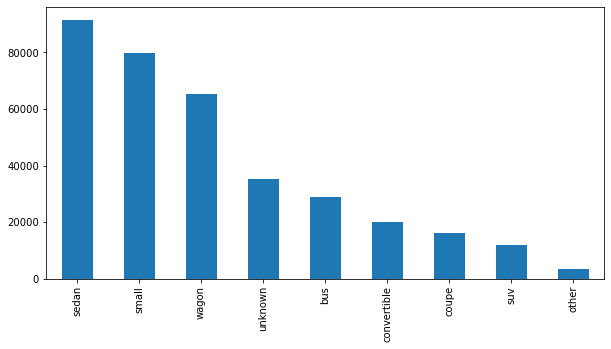

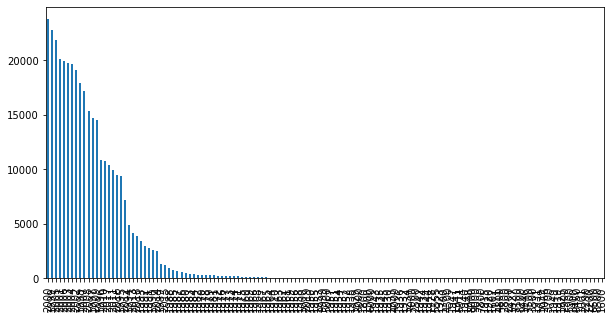

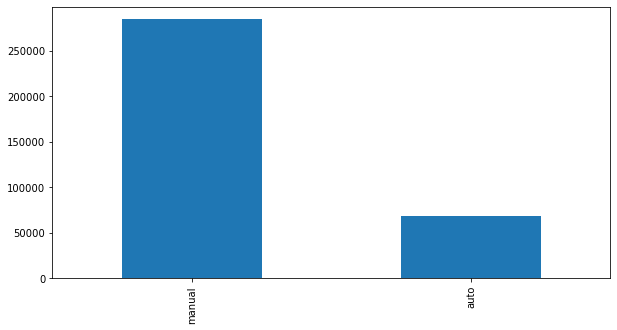

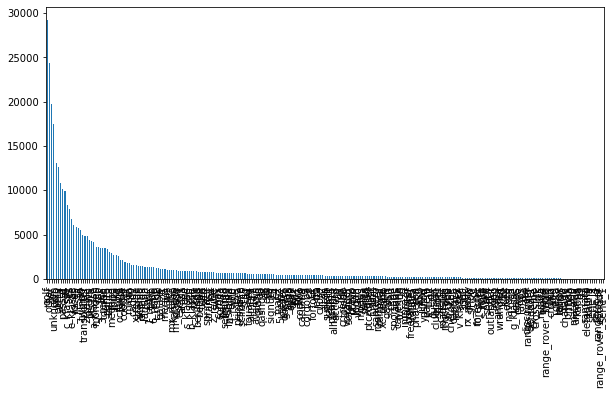

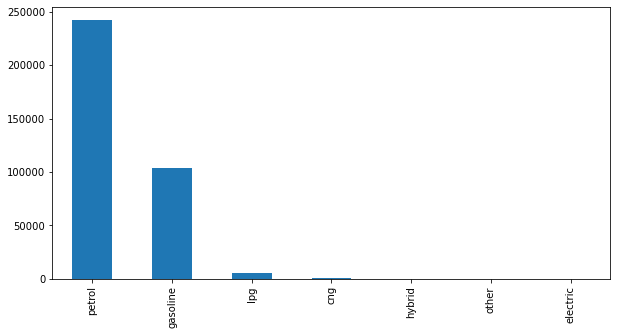

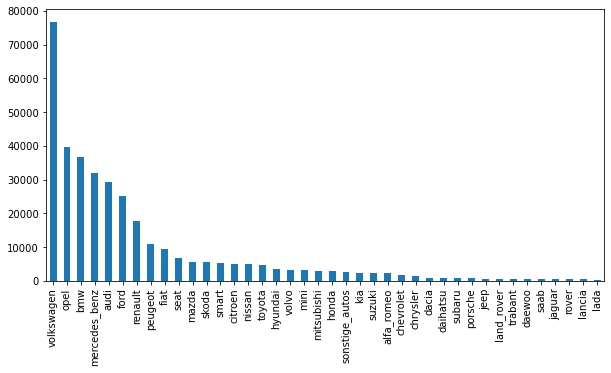

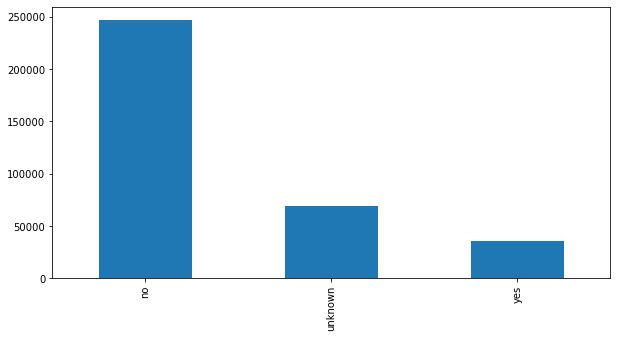

In [20]:
for col in cat_features:
    plt.figure(figsize = (10, 5))
    data[col].value_counts().plot(kind = 'bar')
    plt.show()

Есть ненормальные значения по параметру год регистрации автомобиля. Следует рассматривать значения от 1980 до 2020.

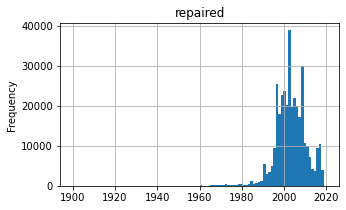

In [21]:
plt.figure(figsize=(5, 3))
data['registration_year'].plot(bins = 100, kind = 'hist', grid = True, range=(1900, 2020))
plt.title(col)
plt.show()

In [22]:
# определим количество таких данных
print(f'Количество анкет до 1980 года и более 2020 года: {data.query("(registration_year < 1980) or (registration_year > 2020)").shape[0]} строк.')

Количество анкет до 1980 года и более 2020 года: 3366 строк.


In [23]:
# удалим такие данные
data = data.query('(registration_year > 1980) and (registration_year < 2020)')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348243 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              348243 non-null  int64 
 1   vehicle_type       348243 non-null  object
 2   registration_year  348243 non-null  int64 
 3   gearbox            348243 non-null  object
 4   power              348243 non-null  int64 
 5   model              348243 non-null  object
 6   kilometer          348243 non-null  int64 
 7   fuel_type          348243 non-null  object
 8   brand              348243 non-null  object
 9   repaired           348243 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.2+ MB


## Рассмотрим числовые/ вещественные признаки

In [24]:
data[num_features].describe()

,price,power,kilometer
count,348243.000000,348243.000000,348243.000000
mean,4414.056314,111.081259,128921.816088
std,4497.560450,188.748805,37064.155950
min,0.000000,0.000000,5000.000000
25%,1100.000000,69.000000,125000.000000
50%,2700.000000,105.000000,150000.000000
75%,6390.000000,143.000000,150000.000000
max,20000.000000,20000.000000,150000.000000


Визуализируем числовые/ вещественные данные

In [25]:
# визуализируем данные, построим графики
def graph_data(data, col):
    plt.figure(figsize=(7, 5))
    data[col].plot(bins = 100, kind = 'hist', grid = True)
    plt.title(col)
    plt.show()
def box_graph_data(data, col):   
    plt.figure(figsize=(7, 5))
    data.boxplot(column = col)
    plt.title(col)
    plt.show()
def individual_data(data, col, n, m):
    plt.figure(figsize=(5, 3))
    data[col].plot(bins = 100, kind = 'hist', grid = True, range=(n, m))
    plt.title(col)
    plt.show()

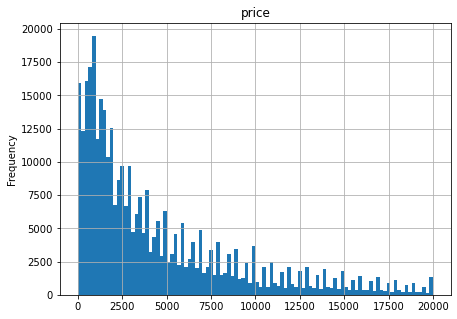

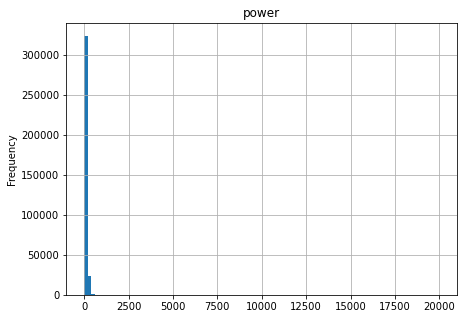

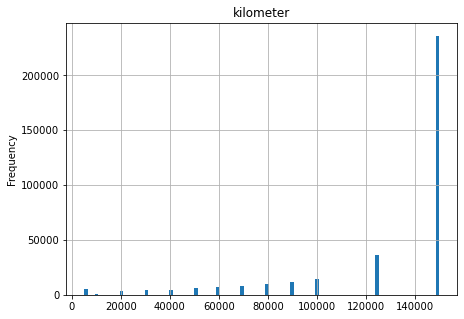

In [26]:
# визуализируем данные с числовыми параметрами
for col in num_features:
    graph_data(data, col)

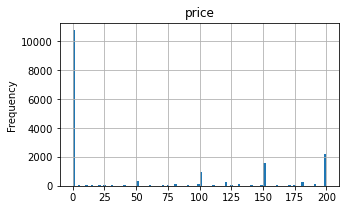

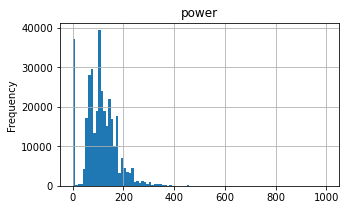

In [27]:
# выведем данные по столбцу price в диапазоне значений от 0 до 200
individual_data(data, 'price', 0, 200)

# выведем данные по столбцу power в диапазоне значений от 0 до 1000
individual_data(data, 'power', 0, 1000)

Из представленных показателей и графиков видно, что есть аномальные/ выбивающиеся значения.

Есть нулевые значения показателя цены автомобиля, то есть не указана его стоимость, данные значения стоит удалить. Для данного параметра возьмем значения больше 50.

Показатели мощности имеет нулевые параметры, а также есть абсурдно большие значения до 20000. Следует избавиться от нулевых значений данного параметра и ограничить мощность до 400.

In [28]:
# определим количество таких данных
print(f'Количество анкет с нулевой стоимостью/ ценой: {data.query("price == 0").shape[0]} строк.')
print(f'Количество анкет с нулевой мощностью автомобиля: {data.query("power == 0").shape[0]} строк.')
print(f'Количество анкет с мощностью автомобиля более 400 л.с.: {data.query("power > 400").shape[0]} строк.')

Количество анкет с нулевой стоимостью/ ценой: 9747 строк.
Количество анкет с нулевой мощностью автомобиля: 36929 строк.
Количество анкет с мощностью автомобиля более 400 л.с.: 709 строк.


In [29]:
# заменим нулевые значения мощности автомобиля медианными значениями сгруппированные по бренду
data['power'] = data.groupby('model')['power'].apply(lambda x: x.replace(0, x.median()))

In [30]:
data.query('power == 0').count()

price                8
vehicle_type         8
registration_year    8
gearbox              8
power                8
model                8
kilometer            8
fuel_type            8
brand                8
repaired             8
dtype: int64

In [31]:
data = data.query('(price > 0) and ((power > 0) and (power < 400))')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337764 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              337764 non-null  int64  
 1   vehicle_type       337764 non-null  object 
 2   registration_year  337764 non-null  int64  
 3   gearbox            337764 non-null  object 
 4   power              337764 non-null  float64
 5   model              337764 non-null  object 
 6   kilometer          337764 non-null  int64  
 7   fuel_type          337764 non-null  object 
 8   brand              337764 non-null  object 
 9   repaired           337764 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 28.3+ MB


In [32]:
# после обработки данных посмотрим есть ли дублирующие данные
print(f'Количество дублирующих строчек данных: {data.duplicated().sum()}')

Количество дублирующих строчек данных: 47448


In [33]:
# удалим дублирующие строки
data = data.drop_duplicates()

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290316 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              290316 non-null  int64  
 1   vehicle_type       290316 non-null  object 
 2   registration_year  290316 non-null  int64  
 3   gearbox            290316 non-null  object 
 4   power              290316 non-null  float64
 5   model              290316 non-null  object 
 6   kilometer          290316 non-null  int64  
 7   fuel_type          290316 non-null  object 
 8   brand              290316 non-null  object 
 9   repaired           290316 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 24.4+ MB


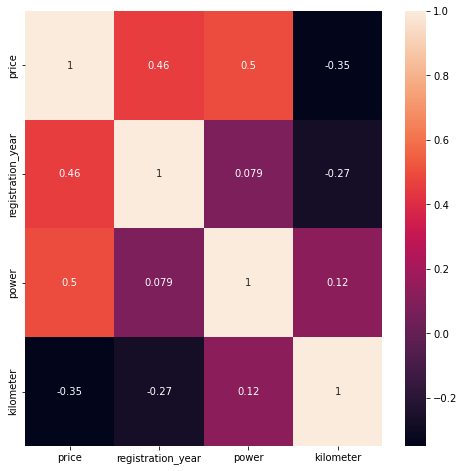

In [35]:
# посмотрим как данные взаимодействуют/ коррелируют между собой
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True)
plt.show()

Посмотрим какой объем от изначального датасета было удалено

In [36]:
print((1 - data.shape[0] / 354368))

0.18074995484919631


После обработки данных 11 процентов данных были удалены из изначального датасета.

## Обучение моделей

In [37]:
# разделим выборки на обучающую и тестовую
X = data.drop(columns=['price'])
y = data['price']

# каждый датасет разобъем на обучающую и валидационную выборку 80:20
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# убедимся в разделении данных на выборки
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(232252, 9)
(58064, 9)
(232252,)
(58064,)


Так как в данных есть категориальные признаки следует привести их к числовым

In [39]:
#переведем категориальные признаки в численные методом OHE (OneHotEncoder)
train_X_ohe = pd.get_dummies(train_X, drop_first=True)
test_X_ohe = pd.get_dummies(test_X, drop_first=True)
display(train_X_ohe.head())
display(test_X_ohe.head())

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
317572,2005,140.0,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35916,2007,55.0,125000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
174426,2005,170.0,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25698,2005,75.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
262101,1996,75.0,50000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
86842,2003,60.0,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
37505,2016,106.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
200051,2004,170.0,125000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324840,2015,105.0,20000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100209,2011,120.0,70000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Рассмотрим модель линейной регрессии

In [40]:
%%time

# обучим модель линейной регрессии
model_lr = LinearRegression()
model_lr.fit(train_X_ohe, train_y)

#применим обученную модель к валидационной выборке для предсказания
prediction_lr = model_lr.predict(train_X_ohe)

# для оценки модели будем использовать метрику оценки RMSE
rmse_lr = mean_squared_error(train_y, prediction_lr,) ** 0.5
print(f'RMSE модели линейной регрессии составляет {rmse_lr}')

RMSE модели линейной регрессии составляет 2512.0218341864593
CPU times: total: 12.7 s
Wall time: 4.49 s


### Рассмотрим модель дерево решений

In [42]:
# для более сложных моделей следует рассмотреть преобразование категориальных признаков методом OE (Ordinal Encoder)
transformation_oe = OrdinalEncoder()

# ранее выделили категориальные признаки в переменную cat_features
train_X_oe = train_X.copy()
test_X_oe = test_X.copy()
train_X_oe[cat_features] = transformation_oe.fit_transform(train_X_oe[cat_features])
test_X_oe[cat_features] = transformation_oe.fit_transform(test_X_oe[cat_features])
display(train_X_oe.head())
display(test_X_oe.head())

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
317572,4.0,24.0,1.0,140.0,28.0,150000,2.0,1.0,0.0
35916,5.0,26.0,1.0,55.0,107.0,125000,6.0,38.0,1.0
174426,5.0,24.0,1.0,170.0,80.0,150000,6.0,21.0,0.0
25698,8.0,24.0,1.0,75.0,101.0,150000,2.0,31.0,1.0
262101,4.0,15.0,1.0,75.0,149.0,50000,6.0,27.0,0.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
86842,5.0,22.0,1.0,60.0,176.0,150000,6.0,9.0,1.0
37505,7.0,35.0,1.0,106.0,28.0,150000,6.0,1.0,1.0
200051,4.0,23.0,0.0,170.0,15.0,125000,6.0,2.0,0.0
324840,0.0,34.0,1.0,105.0,188.0,20000,6.0,31.0,0.0
100209,4.0,30.0,1.0,120.0,42.0,70000,6.0,24.0,0.0


In [45]:
%%time

parametrs_dtr = {'random_state': [RANDOM_STATE], 'max_depth': range (4, 25), 'min_samples_leaf': [20, 30, 40]}

best_model_dtr = GridSearchCV(DecisionTreeRegressor()
                              , parametrs_dtr
                              , cv=5
                              , scoring='neg_root_mean_squared_error'
                              , n_jobs = -1
                              , verbose=5)
best_model_dtr.fit(train_X_oe, train_y)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
CPU times: total: 3.11 s
Wall time: 51.1 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': range(4, 25),
                         'min_samples_leaf': [20, 30, 40],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [46]:
best_model_dtr.best_params_

{'max_depth': 22, 'min_samples_leaf': 20, 'random_state': 12345}

In [47]:
best_model_dtr.best_score_

-1872.1907664157302

### Рассмотрим модель случайного леса

In [48]:
%%time

parametrs_rfr = {'random_state': [RANDOM_STATE], 'n_estimators': [100, 300, 500]
                 , 'max_depth': [7, 12, 17, 22], 'min_samples_leaf': [20]}

best_model_rfr = GridSearchCV(RandomForestRegressor()
                              , parametrs_rfr
                              , cv=5
                              , scoring='neg_root_mean_squared_error'
                              , n_jobs = -1
                              , verbose=5)
best_model_rfr.fit(train_X_oe, train_y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: total: 3min 4s
Wall time: 31min 43s


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [7, 12, 17, 22], 'min_samples_leaf': [20],
                         'n_estimators': [100, 300, 500],
                         'random_state': [12345]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [49]:
best_model_rfr.best_params_

{'max_depth': 22,
 'min_samples_leaf': 20,
 'n_estimators': 500,
 'random_state': 12345}

In [50]:
best_model_rfr.best_score_

-1787.6917989270282

### Рассмотрим модель LightGBMRegressor

In [53]:
%%time

parametrs_lgbmr = {'random_state': [RANDOM_STATE], 'n_estimators': [100, 300, 500]
                   , 'max_depth': range(2, 10) , 'num_leaves': [50, 75, 100], 'learning_rate': [0.4]}

best_model_lgbmr = GridSearchCV(LGBMRegressor()
                                , parametrs_lgbmr
                                , cv=5
                                , scoring='neg_root_mean_squared_error'
                                , n_jobs = -1
                                , verbose=5)
best_model_lgbmr.fit(train_X_oe, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 11 s
Wall time: 6min 23s


GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.4], 'max_depth': range(2, 10),
                         'n_estimators': [100, 300, 500],
                         'num_leaves': [50, 75, 100], 'random_state': [12345]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [54]:
best_model_lgbmr.best_params_

{'learning_rate': 0.4,
 'max_depth': 6,
 'n_estimators': 500,
 'num_leaves': 50,
 'random_state': 12345}

In [55]:
best_model_lgbmr.best_score_

-1635.3096194027178

## Анализ моделей

In [89]:
#функция расчета времени обучения модели
def training_time(model, X, y):
    before_training = time.time()
    model.fit(X, y)
    after_training = time.time()
    time_train = after_training - before_training
    return time_train

#функция расчета времени предсказания модели
def prediction_time(model, X):
    before_predict = time.time()
    prediction = model.predict(X)
    after_predict = time.time()
    time_predict = after_predict - before_predict
    return time_predict

In [90]:
model = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LightGBMRegressor']

params = ['-', best_model_dtr.best_params_, best_model_rfr.best_params_, best_model_lgbmr.best_params_]

rmse_train = [mean_squared_error(train_y, prediction_lr) ** 0.5
              , best_model_dtr.best_score_, best_model_rfr.best_score_, best_model_lgbmr.best_score_]

#rmse_test = [mean_squared_error(test_y_ohe, model_lr.predict(test_X_ohe)) ** 0.5
#             , mean_squared_error(test_y_oe, best_model_dtr.best_estimator_.predict(test_X_oe)) ** 0.5
#             , mean_squared_error(test_y_oe, best_model_rfr.best_estimator_.predict(test_X_oe)) ** 0.5
#             , mean_squared_error(test_y_oe, best_model_lgbmr.best_estimator_.predict(test_X_oe)) ** 0.5]

train_time = [training_time(model_lr, train_X_ohe, train_y)
              , training_time(best_model_dtr.best_estimator_, train_X_oe, train_y)
              , training_time(best_model_rfr.best_estimator_, train_X_oe, train_y)
              , training_time(best_model_lgbmr.best_estimator_, train_X_oe, train_y)]

predict_time = [prediction_time(model_lr, train_X_ohe)
              , prediction_time(best_model_dtr.best_estimator_, train_X_oe)
              , prediction_time(best_model_rfr.best_estimator_, train_X_oe)
              , prediction_time(best_model_lgbmr.best_estimator_, train_X_oe)]

result = {'Model': model, 'Hyperparameters': params, 'RMSE in training': rmse_train
          , 'Training time': train_time, 'Prediction time': predict_time}

display(pd.DataFrame(result))

,Model,Hyperparameters,RMSE in training,Training time,Prediction time
0,LinearRegression,-,2512.021834,4.208759,0.266278
1,DecisionTreeRegressor,"{'max_depth': 22, 'min_samples_leaf': 20, 'random_state': 12345}",-1872.190766,0.597309,0.053983
2,RandomForestRegressor,"{'max_depth': 22, 'min_samples_leaf': 20, 'n_estimators': 500, 'random_state': 12345}",-1787.691799,194.787931,20.710625
3,LightGBMRegressor,"{'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 500, 'num_leaves': 50, 'random_state': 12...",-1635.309619,2.027828,2.637585


Модель линейной регрессии показал худший показатель из всех моделей.
Модель дерева решений справился лучше модели линейной регрессии и показал лучшую скорость обучения.
Модель случайного леса показал неплохой показатель качества, но скорость обучения модели, по сравнению с другими моделями, очень высок.
Модель LightGBM показал самый лучший результат и на обучающей и на тестовой выборках, а также обладает хорошей скоростью обучения и временем предсказания. Модель LightGBM является оптимальным выбором.

## Тестирование лучшей модели

Согласно критериев заказчика для реализации проекта по оценке стоимости автомобиля следует выбрать модель LightGBM с параметрами 'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 500, 'num_leaves': 50, 'random_state': 12345, так как данная модель по сравенению с другими более простыми моделями имеет более точное качество предсказания, а также достаточно быстрое время обучения.

In [91]:
#протестируем выбранную модель на тестовой выборке
print(best_model_lgbmr.best_estimator_)
prediction_lgbmr = best_model_lgbmr.best_estimator_.predict(test_X_oe)
rmse_lgbmr = mean_squared_error(test_y, prediction_lgbmr) ** 0.5
print(f'RMSE рассматриваемой модели LightGBMRegressor на тестовой выборке составляет {rmse_lgbmr}')
print(f'Время обучения модели: {training_time(best_model_lgbmr.best_estimator_, train_X_oe, train_y)} сек.')
print(f'Время предсказания модели: {prediction_time(best_model_lgbmr.best_estimator_, test_X_oe)} сек.')

LGBMRegressor(learning_rate=0.4, max_depth=6, n_estimators=500, num_leaves=50,
              random_state=12345)
RMSE рассматриваемой модели LightGBMRegressor на тестовой выборке составляет 1682.1206783731686
Время обучения модели: 2.158514976501465 сек.
Время предсказания модели: 0.6424777507781982 сек.
